# Ptask comparison to SMPI

Initialisation of the notebook.

Import packages and create directory for the results of the simulations.

In [14]:
import sys 
import os
import math
import datetime
import os
import json
import re
import pprint
import pandas as pd
from subprocess import *
import subprocess
import numpy as np
import matplotlib as plt
from ruamel import yaml
# needed for rumal yaml
from pathlib import Path
import matplotlib.pyplot as plt


from importlib import reload  # Python 3.4+ only.
from IPython.display import Image

cwd = os.getcwd()
print(cwd)
# Adapt this path, it needs to point on the folder containing experiments/exptools.py.
sys.path.insert(1, os.path.abspath("../src"))

import exptools
reload(exptools)


types = {
    'WORD': r'[A-Za-z0-9\-\.]*',
    'NUMBER': r'\d+',
    'FLOAT': r'[0-9\.+-e]+',
    # todo: extend me
}

def compile(pat):
    return re.sub(r'%{(\w+):(\w+)}', 
        lambda m: "(?P<" + m.group(2) + ">" + types[m.group(1)] + ")", pat)


/home/adfaure/Projects/colmet_book/experiments/Ptask_smpi


### System preparations

Creates a directory for the experiment results.

In [15]:
# Creates folder for the simulations inputs and results
cpwd = %pwd

date = datetime.datetime.today().strftime('%Y-%m-%d_%H')

result_dir = os.path.abspath(f'./results/experiments_ptask_auto/{date}')

if not os.path.exists(result_dir):
    os.makedirs(result_dir)
    
print(result_dir)

/home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15


Checking for installed softwares, and compiles the mpi applications: gemmpi.

In [16]:
# From jupyter shell
# activate with `nix-shell environments -A jupyterEnv`
!smpicc --version
!smpirun --version
!ptasked --version

!mpirun --version

SimGrid version 3.24
SimGrid version 3.24
1.2.3
mpirun (Open MPI) 4.0.0

Report bugs to http://www.open-mpi.org/community/help/


The Mpi application is located into a submodule.
Compiling it:

In [17]:
# Build the MPI application
!cd ../gemmpi; ninja gemsmpi

ninja: no work to do.


## Input parameters

In [18]:

reload(exptools)

def play_gemmpi_smpi(expdir="/tmp", nb_host_dahu=32, flops_dahu=1,
                     nbrank=1024, matrice_dims=1024,
                     nb_subdivisions=1,  name_execution=None,
                     no_exec=False, trace_tit = False):
    """
    `matrice_dims`: dimensions of the square matrix.
    `no_exec` bool: usefull to check the parameters before lauching the simulation.
    
    The beginning of the function computes some metrics.
    The firt thing to compute, is depending on the matrix size and the number of processes, what
    will be the number of work on each ranks.
    
    second_per_flops, is a value computed by Tom, it depends on dahu.
    flops_per_core is the speed of a core.
    flops_per_host, however depends on the number of rank and the size of the platform. 
        It represents the speed of a host times the number of rank mapped on each host. 
        It comes from the fact that pdgemm application does not necessarily use all the cores of the machine, 
        this value is intend to be used by batsim.
    """
    yml = yaml.YAML()
    matrice_size = matrice_dims*matrice_dims

    block_size = matrice_size/nbrank
    block_len = math.sqrt(block_size)

    division_len = math.floor(block_len/nb_subdivisions)
    division_size = block_len * division_len

    rank_per_host = nbrank/nb_host_dahu
    second_per_flops = 6.864500e-11
    flops_per_core =  (1/second_per_flops)
    flops_per_host = rank_per_host*flops_per_core
    
    mnk = float(division_len*block_len*block_len)
    mnk_total_loops = mnk*math.sqrt(nbrank)
    
    if no_exec:
        print("matrice_dims", matrice_dims, "matrice size: ", matrice_size)
        print("block_len", block_len, "block size: ", block_size)
        print("division_dimensions", division_len, "x", block_len)
        print("number of rank per host:", rank_per_host, )
        print("Gflops = ", flops_per_host,", mnk", mnk, "loops total ops:", mnk_total_loops)
        print("one matmut should take on one rank=", mnk/flops_per_core, "s")
        print("total memory size of SMPI simulation=", (matrice_size*5*8)/math.pow(10,9), "GB")

        return (None, None)
    
    prefix = "tit_" if trace_tit else "paje_"
    if name_execution is None:
        name_execution = prefix + "nbhost-{}_nbrank-{}_dims-{}_subdivisions-{}".format(nb_host_dahu, nbrank, matrice_dims, nb_subdivisions)

    result_dir = os.path.join(expdir, name_execution)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    
    # The command MPI binary with its params
    smpi_binary = "../gemmpi/gemsmpi -s {nb_subdivisions} {matrice_dims}".format(nb_subdivisions=nb_subdivisions, matrice_dims=matrice_dims)
    # Files name definitions
 
    files = {
        "metadata"   : os.path.join(result_dir, "metadata.yaml"),
        "hostfile"   : os.path.join(result_dir, "dahu-hostfile"),
        "platform"   : os.path.join(result_dir, "dahu-generated.xml"),
        "smpi_out"   : os.path.join(result_dir, "smpi_out"),
        "smpi_err"   : os.path.join(result_dir, "smpi_err"),
        "marks_csv"  : os.path.join(result_dir, "rank_actions.csv"),
        "loops_csv"  : os.path.join(result_dir, "aggregated_events.csv")
    }
    
    exptools.generate_hostfile_dahu(nb_core=nbrank, nb_host=nb_host_dahu, round_robin=False, write=files["hostfile"])
    exptools.generate_dahu_platform_smpi(write=files["platform"], speed=str(flops_per_core/1e+9)+"Gf", radical=nb_host_dahu)
    
    smpi_params_tit  = ""
    smpi_params_paje = ""
    
    # Unfortunatelly paje and tit cannot be ran together
    if trace_tit:
        trace_name_tit = os.path.join(result_dir, "smpi_trace.tit")
        files["tit_trace"] = trace_name_tit
        smpi_params_tit = "-trace-ti -trace-file {trace_name_tit} ".format(trace_name_tit=trace_name_tit)
    else:
        trace_name_paje = os.path.join(result_dir, "smpi_trace.paje")
        files["paje_trace"] = trace_name_paje
        smpi_params_paje = " ".join([
            "-trace -trace-file {trace_name_paje} ",
            "--cfg=tracing/smpi/display-sizes:1",
            # "--cfg=tracing/uncategorized:yes",
            "--cfg=tracing/smpi/internals:1"
        ]).format(trace_name_paje=trace_name_paje)
    
    # Register extra params to print the simulation time
    smpi_extra_params = " --cfg=smpi/display-timing:1 " + smpi_params_paje + " " + smpi_params_tit
    
    # Run smpi simulation
    (smpi_output, smpi_err, smpi_cmd) = exptools.run_smpi(nb_rank=nbrank,
                                                          hostfile=files["hostfile"],
                                                          platform=files["platform"],
                                                          smpi_binary_with_param=smpi_binary,
                                                          smpi_extra_params=smpi_extra_params)
    print(smpi_cmd)
    # Only for gemsmpi application
    # Log outputs
    with open(files["smpi_out"], "w") as tfile:
        print(smpi_output.decode(), file=tfile)
    with open(files["smpi_err"], "w") as tfile:
        print(smpi_err.decode(), file=tfile)

    # Gather logged events and 
    csv = "rank,action,action_event,loop,time\n"
    for line in smpi_output.decode().splitlines():
        if "trace," in line:
            csv_line = line.replace("trace,", "")
            csv += csv_line  + "\n"
    with open(files["marks_csv"], "w") as tfile:
        print(csv, file=tfile)

    p = subprocess.Popen(["Rscript", "scripts/create_loop_timestamps.Rscript",
                          files["marks_csv"], files["loops_csv"] ], stdout=PIPE, stderr=PIPE)
    _, err = p.communicate()

    find_total_time = compile("\[%{FLOAT:total_time_smpi}\] \[smpi_kernel/INFO\] Simulated time: %{FLOAT:total_time_repeat} seconds.")
    find_reality_time = compile("The simulation took %{FLOAT:reality_time} seconds \(after parsing and platform setup\)")
    dictt = re.search(find_total_time, smpi_err.decode()).groupdict()

    total_time_smpi = float(dictt["total_time_smpi"])
    dictt = re.search(find_reality_time, smpi_err.decode()).groupdict()
    reality_time = float(dictt["reality_time"])

    metadata = dict()
    metadata = {
        "inputs": { 
            "name": name_execution,
            "nb_rank": nbrank,
            "nb_rank_per_host": rank_per_host,
            "nb_host_platform": nb_host_dahu,
            "second_per_flops": second_per_flops,
            "flops_per_core": flops_per_core,
            "flops_per_host": flops_per_host,
            "matrice_dims": matrice_dims,
            "nb_subdivison": nb_subdivisions,
            "block_size": block_size,
            "block_len": block_len,
            "division_len": division_len,
            "division_size": division_size,
            "mnk": mnk,
            "expected_time_for_1_dgemm" :mnk/flops_per_core,
            "gemmpi_cmd": smpi_binary,
            "smpi_cmd": smpi_cmd
        },
        "outputs": { 
            "reality_time": reality_time,
            "simulation_time": float(total_time_smpi),
            "result_dir": result_dir,
            "files": files
        }
    }
    yml.dump(metadata, Path(files["metadata"]))
    return metadata

def plot_smpi_application_from_metadata(metadata, start_x=0, start_y=None):
    nb_rank = metadata["inputs"]["nb_rank"]
    nb_divisions = metadata["inputs"]["nb_subdivison"]
    mnk = metadata["inputs"]["mnk"]
    tracefile = metadata["outputs"]["files"]["paje_trace"]
    loops_csv = metadata["outputs"]["files"]["loops_csv"]
    result_dir = metadata["outputs"]["result_dir"] 
    total_time_smpi = metadata["outputs"]["simulation_time"]
    marks_csv = metadata["outputs"]["files"]["marks_csv"]
    
    !pj_dump --ignore-incomplete-links "{tracefile}" > "{tracefile}".csv # Note the --ignore-incomplete-links, which is essential here as the trace is broken

    !grep State "{tracefile}".csv > "{tracefile}".state.csv
    !grep Link "{tracefile}".csv > "{tracefile}".link.csv
    !grep Container "{tracefile}".csv > "{tracefile}".container.csv
    
    if start_y is None:
        start_y = total_time_smpi

    p = subprocess.Popen(["Rscript", "scripts/plotpaje_with_mark.Rscript", 
                          tracefile + ".state.csv",
                          tracefile + ".link.csv",
                          marks_csv,
                          loops_csv,
                          result_dir,
                          str(start_x),
                          str(start_y) ], stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()

    return(os.path.join(result_dir, "comms.png"), os.path.join(result_dir, "p2p.png"))

def batsim_platform_from_metadata(smpi_metadata):
    flops_per_core   = smpi_metadata["inputs"]["flops_per_core"]
    rank_per_host    = smpi_metadata["inputs"]["nb_rank_per_host"]
    nb_host_platform = smpi_metadata["inputs"]["nb_host_platform"]
    mnk = smpi_metadata["inputs"]["mnk"]

    host_speed_Gflops = (flops_per_core*rank_per_host)/(1e+9)
    platform_batsim = exptools.generate_dahu_platform_batsim(speed=str(host_speed_Gflops)+"Gf", radical=nb_host_platform)
    # platform_batsim = exptools.generate_dahu_platform_batsim(speed=str(32*30)+"Gf", radical=nb_host_dahu) 
    return platform_batsim

def profile_mapping_from_smpi_metadata(smpi_metadata):
    smpi_output_file = smpi_metadata["outputs"]["files"]["smpi_out"]
    with open(smpi_output_file) as smpi_ouput:
        (mapping_ranktohost, hosts) = exptools.create_mapping_from_smpirun_output(smpi_ouput.read())
    return (mapping_ranktohost, hosts)

def create_profile_with_mapping_from_smpi(metadata, name = None):
    # Init the matrix
    nb_rank = metadata["inputs"]["nb_rank"]
    nb_divisions = metadata["inputs"]["nb_subdivison"]
    mnk = metadata["inputs"]["mnk"]
    tracefile = metadata["outputs"]["files"]["paje_trace"]
    if name is None: 
        name = metadata["inputs"]["name"] + "_ranks_with_mapping"

    (mapping_ranktohost, hosts) = profile_mapping_from_smpi_metadata(metadata)
    rank_comm_matrix = exptools.creates_communication_matrix_from_smpipaje(
            communication_matrix= [ 0 for x in range(0, nb_rank*nb_rank) ],
            filename=tracefile
        )
    computation_matrix_ranks = [ float(mnk*math.sqrt(nb_rank)*nb_divisions) for x in range(nb_rank) ]

    # Profile generation
    profile_ranks = exptools.generates_ptask_profile(name,
                                                     cpu = computation_matrix_ranks,
                                                     com = rank_comm_matrix)
    return(profile_ranks, mapping_ranktohost)

def create_profile_merged_from_smpi(metadata, name = None):
    # Init the matrix
    nb_rank = metadata["inputs"]["nb_rank"]
    nb_divisions = metadata["inputs"]["nb_subdivison"]
    mnk = metadata["inputs"]["mnk"]
    tracefile = metadata["outputs"]["files"]["paje_trace"]

    if name is None: 
        name = metadata["inputs"]["name"] + "_merged"

    # Firt we need the mapping of the rank to the host.
    (mapping_ranktohost, hosts) = profile_mapping_from_smpi_metadata(metadata)
    nb_hosts = len(hosts)
    # We compute the communication matrix from the paje trace
    
    rank_comm_matrix = exptools.creates_communication_matrix_from_smpipaje(
            communication_matrix= [ 0 for x in range(0, nb_rank*nb_rank) ],
            filename=tracefile)
    computation_matrix_ranks = [ float(mnk*math.sqrt(nb_rank)*nb_divisions) for x in range(nb_rank) ]

    (host_comm_matrix, host_cpu_matrix) =  exptools.merge_communication_matrix(communication_matrix=rank_comm_matrix,
                                                                   computation_matrix=computation_matrix_ranks,
                                                                   mapping=mapping_ranktohost,
                                                                   nb_hosts=nb_hosts,
                                                                   nb_rank=nb_rank)
    
    jobs_hosts = []

    # Profile generation
    profile_hosts = exptools.generates_ptask_profile(name, cpu = host_cpu_matrix, com = host_comm_matrix)

    return (profile_hosts, nb_hosts)


def create_profile_sequence_from_smpi(metadata, name = None, merge_com_and_cpu=True):
    # Init the matrix
    nb_rank = metadata["inputs"]["nb_rank"]
    nb_divisions = metadata["inputs"]["nb_subdivison"]
    mnk = metadata["inputs"]["mnk"]
    tracefile = metadata["outputs"]["files"]["paje_trace"]
    loops_csv = metadata["outputs"]["files"]["loops_csv"]
    
    profile_name = name
    if name is None:
        profile_name = metadata["inputs"]["name"]+"_sequence"

    intervals = []
    # create intervals from the result of the Rscript -> create_loop_timestamps.Rscript 
    for (id_, row) in pd.read_csv(loops_csv).iterrows():
        row[row["loop"]] = []
        # Intervals are tuple of int
        intervals.append((
            row["loop"],
            float(row["min_bcast_begin"]),
            float(row["min_comp_end"]))
        )

    matrixes = exptools.creates_communication_matrix_from_smpipaje_with_intervals(nb_rank=nb_rank,
                                                                                  filename=tracefile,
                                                                                  intervals=intervals,
                                                                                  include_bound=True)
    splitted_comp_matrix = [ float(mnk) for x in range(nb_rank) ]
    # used in the separated com and cpu profile
    empty_cpu = [0]*nb_rank
    empty_comm = [0]*nb_rank*nb_rank

    seq_profiles = []
    sequence_names = []
    for (key, item) in matrixes.items():
        seq_name = profile_name + "_sequence_{}".format(key)
        sequence_names.append(seq_name)
        if merge_com_and_cpu:
            seq_profile = exptools.generates_ptask_profile(name=seq_name, com=item, cpu=splitted_comp_matrix)
            seq_profiles.append(seq_profile)
        else:
            seq_profile = exptools.generates_ptask_profile(name=seq_name+"_com", com=item, cpu=empty_cpu)
            seq_profiles.append(seq_profile)
            seq_profile = exptools.generates_ptask_profile(name=seq_name+"_cpu", com=empty_comm, cpu=splitted_comp_matrix)
            seq_profiles.append(seq_profile)         
    
    # The needed mapping for the batsim job
    (mapping_ranktohost, hosts) = profile_mapping_from_smpi_metadata(metadata)

    (root_profile, profile_sequence) = exptools.generates_ptask_profile_sequence(profile_name, profiles=seq_profiles, repeat=1)
    
    return (root_profile, profile_sequence, mapping_ranktohost)

def run_batsim_from_smpi_paje(metadata, name=None, profile_type="ranks"):
    # Init the matrix
    nb_rank = metadata["inputs"]["nb_rank"]
    nb_divisions = metadata["inputs"]["nb_subdivison"]
    mnk = metadata["inputs"]["mnk"]
    
    if "paje_trace" not in metadata["outputs"]["files"]:
        raise ValueError('The metadata informations doesn\'t contains a paje_trace')
    
    tracefile = metadata["outputs"]["files"]["paje_trace"]

    job_res  = 0
    job_data = dict()
    profiles = []
    if profile_type == "ranks":
        (profile, mapping_ranktohost) = create_profile_with_mapping_from_smpi(metadata)
        job_data = {"mapping": mapping_ranktohost}
        job_res  = nb_rank 
        profiles.append(profile)
    elif profile_type == "merged":
        (profile, nb_hosts) = create_profile_merged_from_smpi(metadata)
        job_res = nb_hosts
        profiles.append(profile)
    elif profile_type == "sequence":
        (profile, profiles_seq, mapping_ranktohost) = create_profile_sequence_from_smpi(metadata)
        job_res = nb_rank
        job_data = {"mapping": mapping_ranktohost}
        profiles.append(profile)
        profiles += profiles_seq
    elif profile_type == "sequence_separated":
        (profile, profiles_seq, mapping_ranktohost) = create_profile_sequence_from_smpi(metadata, merge_com_and_cpu=False)
        job_res = nb_rank
        job_data = {"mapping": mapping_ranktohost}
        profiles.append(profile)
        profiles += profiles_seq

    profile_name = list(profile.keys())[0]
    
    jobs_ranks = []
    # Create jobs
    job_ranks =  exptools.gen_job(id_job=0, subtime=0, walltime=-1, res=job_res, profile=profile_name, data=job_data)
    
    jobs_ranks.append(job_ranks)
    
    platform_batsim = batsim_platform_from_metadata(metadata)
    workload = exptools.gen_workload(jobs_ranks, profiles , nb_res=nb_rank)
    
    if name is None:
        name = profile_type
    
    (out, err, outputdir) = exptools.prepare_and_run(base_directory=result_dir, 
                                     platform=platform_batsim, 
                                     workload=workload,
                                     mpi_tracing = True,
                                     sched_command="RUST_LOG=trace ptasked",
                                     instance_name=name + "_" + metadata["inputs"]["name"],
                                     master="master_host0")

    dataframe = pd.read_csv(f"{outputdir}/outputs/out_jobs.csv")
    total_time_matrice_rank = dataframe["execution_time"][0]
    return dataframe

def run_batsim_from_smpi_tit(metadata, name=None):
    # Init the matrix
    nb_rank = metadata["inputs"]["nb_rank"]
    nb_divisions = metadata["inputs"]["nb_subdivison"]
    mnk = metadata["inputs"]["mnk"]
    
    if "tit_trace" not in metadata["outputs"]["files"]:
        raise ValueError('The metadata informations doesn\'t contains a tit_trace') 

    tracefile = metadata["outputs"]["files"]["tit_trace"]

    (mapping, hosts) = profile_mapping_from_smpi_metadata(metadata)
    profile  = create_profile_from_tit(metadata)
    job_data = { "mapping": mapping }
    job_res  = nb_rank
    
    profile_name = list(profile.keys())[0]
    jobs_ranks = []
    # Create jobs
    job_ranks =  exptools.gen_job(id_job=0, subtime=0, walltime=-1, res=job_res, profile=profile_name, data=job_data)
    jobs_ranks.append(job_ranks)
    
    flops_per_core   = metadata["inputs"]["flops_per_core"]
    nb_host_platform = metadata["inputs"]["nb_host_platform"]
    rank_per_host    = metadata["inputs"]["nb_rank_per_host"]

    platform_batsim = exptools.generate_dahu_platform_batsim(speed=str(rank_per_host * flops_per_core/1e+9)+"Gf", radical=nb_host_platform)
    # platform_batsim = batsim_platform_from_metadata(metadata)
    
    workload = exptools.gen_workload(jobs_ranks, [profile],nb_res=nb_rank)

    if name is None:
        name = "batsim"
    
    (out, err, outputdir) = exptools.prepare_and_run(base_directory=result_dir, 
                                     platform=platform_batsim,
                                     workload=workload,
                                     mpi_tracing = True,
                                     sched_command="RUST_LOG=trace ptasked",
                                     instance_name=name + "_" + metadata["inputs"]["name"],
                                     master="master_host0")

    dataframe = pd.read_csv(f"{outputdir}/outputs/out_jobs.csv")
    total_time_matrice_rank = dataframe["execution_time"][0]
    return (dataframe, outputdir)


def create_profile_from_tit(metadata, name = None):
    # Init the matrix
    nb_rank = metadata["inputs"]["nb_rank"]
    nb_divisions = metadata["inputs"]["nb_subdivison"]
    mnk = metadata["inputs"]["mnk"]
    tracefile = metadata["outputs"]["files"]["tit_trace"]

    if name is None: 
        name = metadata["inputs"]["name"] + "_tit"
    return {
        name: {
            "type": "smpi",
            "trace": tracefile
        }
    }

In [19]:
# Build the MPI application
!rm gemmpi/gemsmpi
!cd ../gemmpi; ninja gemsmpi

rm: cannot remove 'gemmpi/gemsmpi': No such file or directory
ninja: no work to do.


In [33]:
math.sqrt(1024)

(80e3 / 32)

2500.0

In [39]:
nrank = 1024
matrice_dims = 80*1000

metadata_tit = play_gemmpi_smpi(expdir = result_dir,
                                matrice_dims=matrice_dims,
                                nbrank=nrank,
                                nb_subdivisions=50,
                                nb_host_dahu=32,
                                no_exec=False, trace_tit=False)

print("tit", metadata_tit["outputs"])

smpirun -map -np 1024 -hostfile /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/paje_nbhost-32_nbrank-1024_dims-80000_subdivisions-50/dahu-hostfile -platform /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/paje_nbhost-32_nbrank-1024_dims-80000_subdivisions-50/dahu-generated.xml  --cfg=smpi/display-timing:1 -trace -trace-file /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/paje_nbhost-32_nbrank-1024_dims-80000_subdivisions-50/smpi_trace.paje  --cfg=tracing/smpi/display-sizes:1 --cfg=tracing/smpi/internals:1  ../gemmpi/gemsmpi -s 50 80000
tit {'reality_time': 174.193, 'simulation_time': 55.993161, 'result_dir': '/home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/paje_nbhost-32_nbrank-1024_dims-80000_subdivisions-50', 'files': {'metadata': '/home/adfaure/Projects/colmet_book/

In [22]:
reload(exptools)
# create_profile_from_tit(metadata)
(dataframe, outdir) = run_batsim_from_smpi_tit(metadata_tit)
dataframe["execution_time"]

0    17.827906
Name: execution_time, dtype: float64

In [40]:
nrank = 16
matrice_dims = 16*1000

metadata_paje = play_gemmpi_smpi(expdir = result_dir,
                                matrice_dims=matrice_dims,
                                nbrank=nrank,
                                nb_subdivisions=1,
                                nb_host_dahu=2,
                                no_exec=False, trace_tit=False)

print("paje", metadata_paje["outputs"]["simulation_time"])

run_batsim_from_smpi_paje(metadata_paje, profile_type="ranks", name="mappings")["execution_time"]

smpirun -map -np 16 -hostfile /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/paje_nbhost-2_nbrank-16_dims-16000_subdivisions-1/dahu-hostfile -platform /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/paje_nbhost-2_nbrank-16_dims-16000_subdivisions-1/dahu-generated.xml  --cfg=smpi/display-timing:1 -trace -trace-file /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/paje_nbhost-2_nbrank-16_dims-16000_subdivisions-1/smpi_trace.paje  --cfg=tracing/smpi/display-sizes:1 --cfg=tracing/smpi/internals:1  ../gemmpi/gemsmpi -s 1 16000
paje 17.90278


0    17.57312
Name: execution_time, dtype: float64

In [51]:
nb_rank = 16

results = []
for i in [8, 40, 60, 80]:
    matrice_dimensions = i*1000

    metadata = play_gemmpi_smpi(expdir = result_dir, 
                                    matrice_dims=matrice_dimensions,
                                    nbrank=nb_rank,
                                    nb_subdivisions=50,
                                    nb_host_dahu=32,
                                    no_exec=False)
    
    metadata_tit = play_gemmpi_smpi(expdir = result_dir,
                                    matrice_dims=matrice_dimensions,
                                    nbrank=nb_rank,
                                    nb_subdivisions=50,
                                    nb_host_dahu=32,
                                    no_exec=False,
                                    trace_tit = True)
    
    # plot_smpi_application_from_metadata(metadata)

    # continue
    loops_events = pd.read_csv(metadata["outputs"]["files"]["loops_csv"])
    last_loop = loops_events[-1:].get("loop").to_numpy()[0]
    smpi_time = metadata["outputs"]["simulation_time"]
    smpi_with_tit = metadata_tit["outputs"]["simulation_time"]

    max_first_bcast = loops_events[loops_events["loop"] == 0]["max_bcast_begin"][0]
    min_first_bcast = loops_events[loops_events["loop"] == 0]["min_bcast_begin"][0]
    max_last_comp = smpi_time - loops_events[loops_events["loop"] == last_loop]["max_comp_end"].to_numpy()[0]
    min_last_comp = smpi_time - loops_events[loops_events["loop"] == last_loop]["min_comp_end"].to_numpy()[0]

    time_sequence_separated = run_batsim_from_smpi_paje(metadata,
                                                        profile_type="sequence_separated",
                                                        name="rr_seq_sep")["execution_time"][0]
    
    time_merged = run_batsim_from_smpi_paje(metadata, profile_type="merged",
                                            name="rr_merged")["execution_time"][0]
    
    time_ranks = run_batsim_from_smpi_paje(metadata, profile_type="ranks",
                                           name="rr_ranks")["execution_time"][0]

    time_sequence = run_batsim_from_smpi_paje(metadata, profile_type="sequence",
                                              name="rr_sequence")["execution_time"][0]
    
    time_tit = run_batsim_from_smpi_tit(metadata_tit)[0]["execution_time"][0]

    results.append([matrice_dimensions,
                    smpi_time,
                    time_merged,
                    time_ranks,
                    time_sequence,
                    time_sequence_separated,
                    time_tit,
                    smpi_with_tit])

smpirun -map -np 16 -hostfile /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/paje_nbhost-32_nbrank-16_dims-8000_subdivisions-50/dahu-hostfile -platform /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/paje_nbhost-32_nbrank-16_dims-8000_subdivisions-50/dahu-generated.xml  --cfg=smpi/display-timing:1 -trace -trace-file /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/paje_nbhost-32_nbrank-16_dims-8000_subdivisions-50/smpi_trace.paje  --cfg=tracing/smpi/display-sizes:1 --cfg=tracing/smpi/internals:1  ../gemmpi/gemsmpi -s 50 8000
smpirun -map -np 16 -hostfile /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-17_15/tit_nbhost-32_nbrank-16_dims-8000_subdivisions-50/dahu-hostfile -platform /home/adfaure/Projects/colmet_book/experiments/Ptask_smpi/results/experiments_ptask_auto/2020-03-

In [52]:
data = np.array(results)
df = pd.DataFrame({
    'matrice_dimensions':data[:,0],
    'smpi_total_time':data[:,1],
    'merged_comms': data[:,2],
    'ranks_with_mapping': data[:,3],
    'time_sequence': data[:,4],
    'time_sequence_separated_com_cpu': data[:,5],
    'time_tit': data[:,6],
    "smpi_tt_time_tit": data[:,7]
})

df

matrice_dimensions  smpi_total_time  merged_comms  ranks_with_mapping  \
0              8000.0         2.249288       4.39328             4.39328   
1             40000.0       275.646091     549.16000           549.16000   
2             60000.0       929.093179    1853.41500          1853.41500   
3             80000.0      2200.873101    4393.28000          4393.28000   

   time_sequence  time_sequence_separated_com_cpu     time_tit  \
0        4.39330                         4.432878     4.475340   
1      549.16002                       550.148180   551.208135   
2     1853.41502                      1855.623980  1858.023141   
3     4393.28002                      4397.237780  4401.472140   

   smpi_tt_time_tit  
0          2.249288  
1        275.646091  
2        929.093179  
3       2200.873101

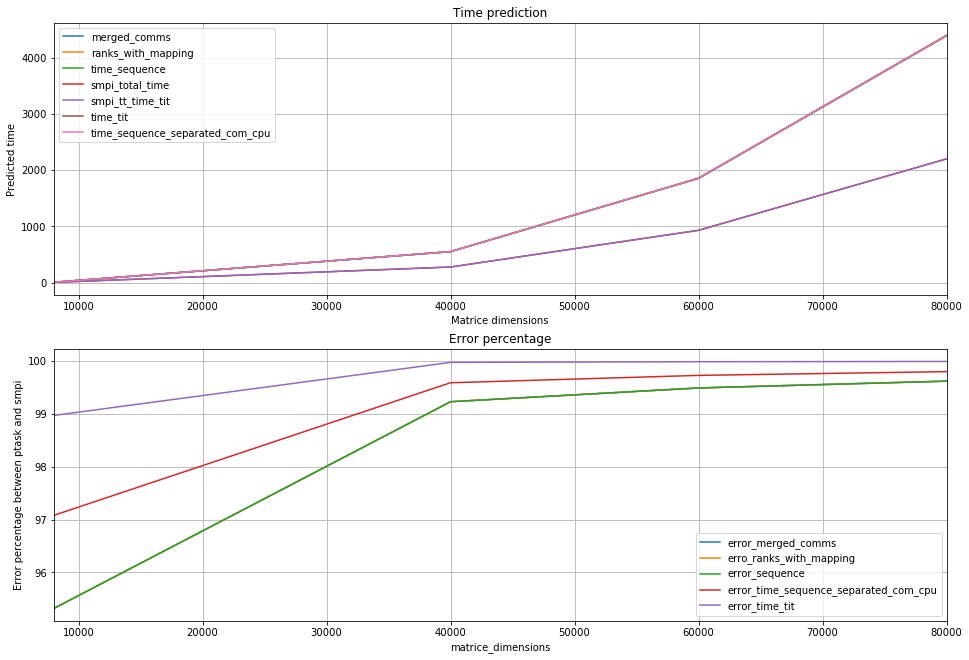

In [53]:
df = df.assign(error_merged_comms = lambda x: 100*(abs(x.smpi_total_time - x.merged_comms)) / x.smpi_total_time)
df = df.assign(erro_ranks_with_mapping = lambda x: 100*abs(x.smpi_total_time - x.ranks_with_mapping) / x.smpi_total_time)
df = df.assign(error_sequence = lambda x: 100*abs(x.smpi_total_time - x.time_sequence) / x.smpi_total_time)
df = df.assign(error_time_sequence_separated_com_cpu = lambda x: 100*abs(x.smpi_total_time - x.time_sequence_separated_com_cpu) / x.smpi_total_time)
df = df.assign(error_time_tit = lambda x: 100*abs(x.smpi_tt_time_tit - x.time_tit) / x.smpi_tt_time_tit)

fig, axs = plt.subplots(2, 1, figsize=(16, 11))

df.plot(kind='line',x='matrice_dimensions',y='merged_comms', ax=axs[0])
df.plot(kind='line',x='matrice_dimensions',y='ranks_with_mapping', ax=axs[0])
df.plot(kind='line',x='matrice_dimensions',y='time_sequence', ax=axs[0])
df.plot(kind='line',x='matrice_dimensions',y='smpi_total_time', ax=axs[0])
df.plot(kind='line',x='matrice_dimensions',y='smpi_tt_time_tit', ax=axs[0])
df.plot(kind='line',x='matrice_dimensions',y='time_tit', ax=axs[0])
df.plot(kind='line',x='matrice_dimensions',y='time_sequence_separated_com_cpu', ax=axs[0])
axs[0].set_title("Time prediction")
axs[0].set_xlabel("Matrice dimensions")
axs[0].set_ylabel("Predicted time")


df.plot(kind='line',x='matrice_dimensions',y='error_merged_comms', ax=axs[1])
df.plot(kind='line',x='matrice_dimensions',y='erro_ranks_with_mapping', ax=axs[1])
df.plot(kind='line',x='matrice_dimensions',y='error_sequence', ax=axs[1])
df.plot(kind='line',x='matrice_dimensions',y='error_time_sequence_separated_com_cpu', ax=axs[1])
df.plot(kind='line',x='matrice_dimensions',y='error_time_tit', ax=axs[1])

axs[1].set_title("Error percentage")
axs[1].set_ylabel("Error percentage between ptask and smpi")

axs[0].grid(True)
axs[1].grid(True)

plt.show()